In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import copy
import random as rand

data = pd.read_csv("c:\\Users\\markm\\Desktop\\CAPSTONE\\capstone\\data\\external\\watson_healthcare_modified.csv")

c:\Users\markm\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
data.head()


,EmployeeID,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,...,RelationshipSatisfaction,StandardHours,Shift,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1313919,41,No,Travel_Rarely,1102,Cardiology,1,2,Life Sciences,1,...,1,80,0,8,0,1,6,4,0,5
1,1200302,49,No,Travel_Frequently,279,Maternity,8,1,Life Sciences,1,...,4,80,1,10,3,3,10,7,1,7
2,1060315,37,Yes,Travel_Rarely,1373,Maternity,2,2,Other,1,...,2,80,0,7,3,3,0,0,0,0
3,1272912,33,No,Travel_Frequently,1392,Maternity,3,4,Life Sciences,1,...,3,80,0,8,3,3,8,7,3,0
4,1414939,27,No,Travel_Rarely,591,Maternity,2,1,Medical,1,...,4,80,1,6,3,3,2,2,2,2


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   EmployeeID                1676 non-null   int64 
 1   Age                       1676 non-null   int64 
 2   Attrition                 1676 non-null   object
 3   BusinessTravel            1676 non-null   object
 4   DailyRate                 1676 non-null   int64 
 5   Department                1676 non-null   object
 6   DistanceFromHome          1676 non-null   int64 
 7   Education                 1676 non-null   int64 
 8   EducationField            1676 non-null   object
 9   EmployeeCount             1676 non-null   int64 
 10  EnvironmentSatisfaction   1676 non-null   int64 
 11  Gender                    1676 non-null   object
 12  HourlyRate                1676 non-null   int64 
 13  JobInvolvement            1676 non-null   int64 
 14  JobLevel                

In [4]:
# let's slice the data into x and y, for building predictive models
y = data['Attrition']
x = data.drop(columns=['EmployeeID','Attrition'])

In [5]:
print(x.shape)
print(y.shape)

(1676, 33)
(1676,)


In [6]:
y.value_counts()

No     1477
Yes     199
Name: Attrition, dtype: int64

In [7]:
y.replace('No', 0, inplace=True)
y.replace('Yes', 1, inplace = True)

<Figure size 1152x576 with 0 Axes>

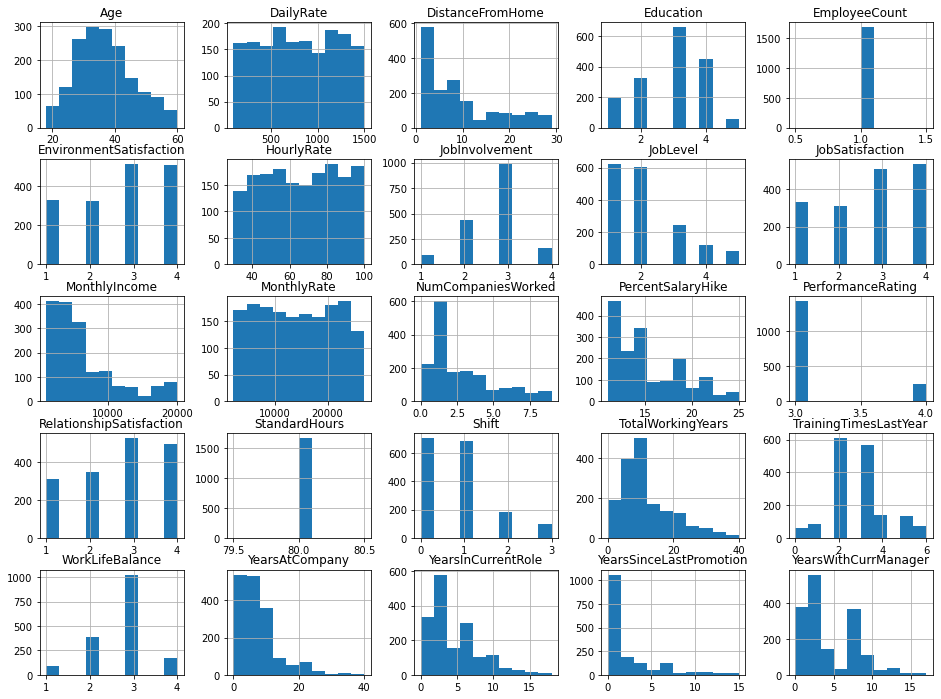

In [8]:
# plot histograms of each numerical value
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16,8))
x.hist(figsize = (16,12))

plt.show()


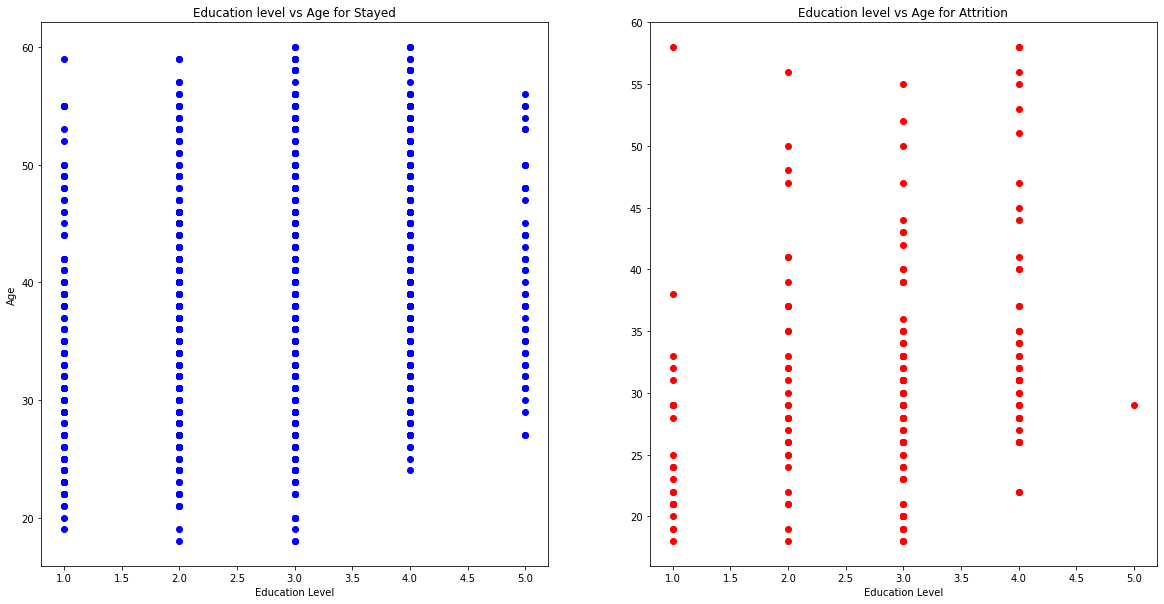

In [9]:
# now let's look at some of the columns with the y value as well
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))


ax[0].scatter(data.Education[data.Attrition==0], data.Age[data.Attrition==0], c='b', label = 'stayed')


ax[1].scatter(data.Education[data.Attrition==1], data.Age[data.Attrition==1], c='r', label = 'attrited')


ax[0].set_xlabel('Education Level')
ax[0].set_ylabel('Age')
ax[1].set_xlabel('Education Level')

ax[0].set_title('Education level vs Age for Stayed', loc='center')
ax[1].set_title('Education level vs Age for Attrition', loc='center')

plt.show()

In [10]:
# Check the Over18 column to see if there is variation in this feature
x.Over18.unique()

array(['Y'], dtype=object)

In [11]:
# based off of this analysis, let's drop 'EmployeeCount' & 'StandardHours' because there is no interesting patterns in these features
x = x.drop(columns=['Over18','EmployeeCount','StandardHours'], axis=1)

## Now that we have initially analyzed the data, let's pass this data into 'LazyClassifier' to figure out which models could work best with the model

In [12]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\markm\anaconda3\lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [13]:
x_train_l, x_test_l, y_train_l, y_test_l = train_test_split(x,y, test_size =0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(x_train_l,x_test_l,y_train_l,y_test_l)

models

100%|██████████| 29/29 [00:03<00:00,  8.71it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
Perceptron,0.88,0.79,0.79,0.89,0.04
LinearSVC,0.92,0.79,0.79,0.92,0.13
LogisticRegression,0.92,0.78,0.78,0.92,0.12
PassiveAggressiveClassifier,0.89,0.78,0.78,0.89,0.05
AdaBoostClassifier,0.93,0.77,0.77,0.92,0.25
SGDClassifier,0.91,0.75,0.75,0.90,0.04
NearestCentroid,0.71,0.74,0.74,0.75,0.14
CalibratedClassifierCV,0.92,0.74,0.74,0.91,0.21
LinearDiscriminantAnalysis,0.91,0.73,0.73,0.90,0.07


In [14]:
data.select_dtypes(include=['object']).head(2)

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Travel_Rarely,Cardiology,Life Sciences,Female,Nurse,Single,Y,Yes
1,Travel_Frequently,Maternity,Life Sciences,Male,Other,Married,Y,No


In [15]:
print("Department: ", data.Department.unique())
print("Business Travel: ",data.BusinessTravel.unique())
print("EducationField: ",data.EducationField.unique())
print("Gender: ",data.Gender.unique())
print("JobRole: ",data.JobRole.unique())
print("MaritalStatus	: ",data.MaritalStatus	.unique())
print("Over18: ",data.Over18.unique())
print("OverTime: ", data.OverTime.unique())


Department:  ['Cardiology' 'Maternity' 'Neurology']
Business Travel:  ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
EducationField:  ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender:  ['Female' 'Male']
JobRole:  ['Nurse' 'Other' 'Therapist' 'Administrative' 'Admin']
MaritalStatus	:  ['Single' 'Married' 'Divorced']
Over18:  ['Y']
OverTime:  ['Yes' 'No']


In [16]:
data.select_dtypes(include=['object']).columns

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')

### Analysis
- Because we don't see many unique responses to any of these variables, *with Educational Field having the most with 6*, I am going to encode these variables in place rather than using get_dummies()

In [17]:
pd.get_dummies(x['Department'], prefix='Department')

,Department_Cardiology,Department_Maternity,Department_Neurology
0,1,0,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
1671,0,0,1
1672,1,0,0
1673,0,1,0
1674,0,0,1


In [18]:
### Script for parsing data for neural networks
def convert_numeric(data):

    # Get one hot encoding of columns B
    data_ohe = data
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        col_ohe = pd.get_dummies(data[col], prefix=col)
        data_ohe = pd.concat((data_ohe, col_ohe), axis=1).drop(col, axis=1)

    return data_ohe

In [19]:
x = convert_numeric(x)

x.head(2)

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,JobRole_Admin,JobRole_Administrative,JobRole_Nurse,JobRole_Other,JobRole_Therapist,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,2,4,5993,...,0,0,1,0,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,2,5130,...,0,0,0,1,0,0,1,0,1,0


## First Method : Logistic Regression

### Base model with unbalanced target variable

In [20]:
# create the logistic regression  model
from sklearn.linear_model import LogisticRegression

# create the base instance of the model for exploration
log_r = LogisticRegression()


In [21]:
# split the data after numeric conversion
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size =0.2, random_state=42)

# fit the data on the training data
log_r.fit(x_train, y_train)

LogisticRegression()

In [22]:
predictions = log_r.predict(x_test)
score = log_r.score(x_test, y_test)
print(score)

0.8571428571428571


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report

cm = metrics.confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.87      0.99      0.92       289
           1       0.43      0.06      0.11        47

    accuracy                           0.86       336
   macro avg       0.65      0.52      0.52       336
weighted avg       0.81      0.86      0.81       336



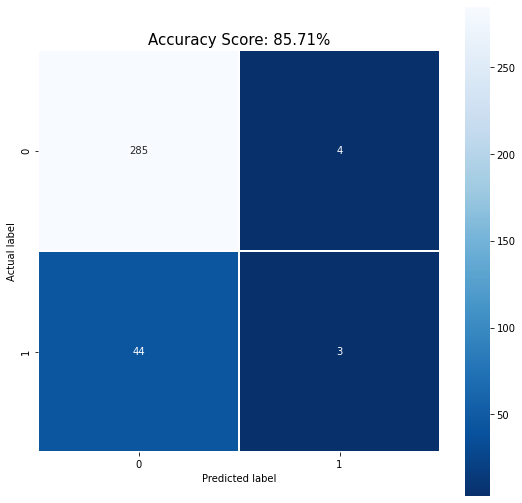

In [24]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.2f}%'.format(score*100, {"3f"})
plt.title(all_sample_title, size = 15);

print(classification_report(y_test,predictions))

### Let's try running the base model after balancing the data set to see if we have improvement

In [25]:
# pip install imbalanced-learn
import imblearn

from imblearn.over_sampling import SMOTE

# transform the dataset
oversample = SMOTE()
x_bal_train, y_bal_train = oversample.fit_resample(x_train, y_train)

In [26]:

# fit the data on the balanced training data
log_r.fit(x_bal_train, y_bal_train)

LogisticRegression()

In [27]:
predictions = log_r.predict(x_test)
score = log_r.score(x_test, y_test)
print(score)

0.7113095238095238


              precision    recall  f1-score   support

           0       0.92      0.73      0.81       289
           1       0.26      0.60      0.37        47

    accuracy                           0.71       336
   macro avg       0.59      0.66      0.59       336
weighted avg       0.83      0.71      0.75       336



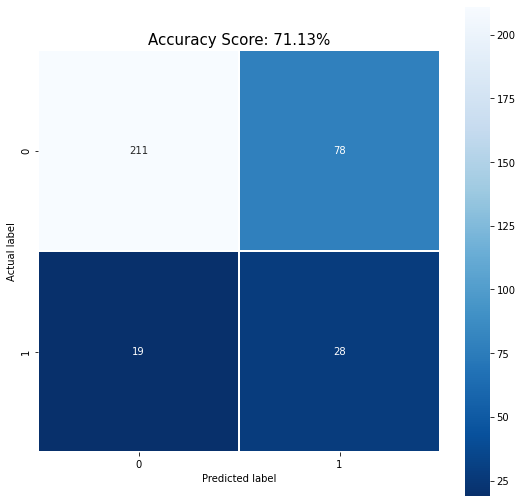

In [28]:
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {:.2f}%'.format(score*100, {"3f"})
plt.title(all_sample_title, size = 15);

print(classification_report(y_test,predictions))

## Second Model : Neural Network

In [29]:
#define custom loss for unbalanced data set using inverse weights

class CrossEntropyLoss(tf.keras.losses.Loss):

    def __init__(self):

        super().__init__(name='CrossEntropyLoss')

 

    def call(self, y_true, y_pred):

        """

        Cross entropy loss adjusted for class imabalance and one-hot encoding sparsity

        """

        y_true = tf.cast(y_true, dtype=tf.float64)

        y_pred = tf.cast(y_pred, dtype=tf.float64)

 

        epsilon = tf.constant(1e-7, dtype=tf.float64) #avoid nans

        loss = (tf.math.log(y_pred+epsilon)*y_true + tf.math.log((1-y_pred)+epsilon) * (1-y_true))*-1.0

        tf.debugging.assert_all_finite(loss, 'There are nan values')

        return tf.reduce_sum(tf.reduce_mean(loss, axis = 0))

 

class ClassImbalanceSparsityAdjustedCEL(tf.keras.losses.Loss):

    def __init__(self, inverse_class_weights):

        """

        Initialization of inverse class weights

        """

        super().__init__(name='ClassImbalanceSparsityAdjustedCEL')

        self.inverse_class_weights = inverse_class_weights

 

    def call(self, y_true, y_pred):

        """

        Cross entropy loss adjusted for class imabalance and one-hot encoding sparsity

        """

        P = tf.reduce_sum(y_true)

        N = -1 * tf.reduce_sum(y_true - 1)

 

        beta_P = tf.cast((P + N) / P, dtype=tf.float64)

        beta_N = tf.cast((P + N) / N, dtype=tf.float64)

 

        y_true = tf.cast(y_true, dtype=tf.float64)

        y_pred = tf.cast(y_pred, dtype=tf.float64)

 

        epsilon = tf.constant(1e-7, dtype=tf.float64) #avoid nans

        loss = (beta_P*tf.math.log(y_pred+epsilon)*y_true + beta_N*tf.math.log((1-y_pred)+epsilon) * (1-y_true))*-1.0

        tf.debugging.assert_all_finite(loss, 'There are nan values')

        return tf.reduce_sum(tf.reduce_mean(loss, axis = 0)*self.inverse_class_weights)

 



In [30]:
y.value_counts()

0    1477
1     199
Name: Attrition, dtype: int64

In [31]:
# function to plot accuracy and loss

import matplotlib.pyplot as plt
%matplotlib inline

def plot_acc_loss(history):
    
    plt.figure(1)  

    # summarize history for accuracy  

    plt.subplot(211)  
    plt.plot(history.history['precision'])  
    plt.plot(history.history['val_precision'])  
    plt.title('PRECISION')  
    plt.ylabel('Precision ratio')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='upper left')  

    # summarize history for loss  

    plt.subplot(212)  
    plt.plot(history.history['loss'])  
    plt.plot(history.history['val_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('epoch')  
    plt.legend(['train', 'val'], loc='upper left')

    plt.tight_layout()
    plt.show() 
    
    return

****** With Normalization Layer *******
Epoch 1/200
42/42 - 1s - loss: 1.3307 - precision: 0.5000 - val_loss: 0.9662 - val_precision: 0.5000 - 1s/epoch - 29ms/step
Epoch 2/200
42/42 - 0s - loss: 0.7668 - precision: 0.5000 - val_loss: 0.5925 - val_precision: 0.5000 - 145ms/epoch - 3ms/step
Epoch 3/200
42/42 - 0s - loss: 0.4956 - precision: 0.5000 - val_loss: 0.4511 - val_precision: 0.5000 - 138ms/epoch - 3ms/step
Epoch 4/200
42/42 - 0s - loss: 0.3939 - precision: 0.5000 - val_loss: 0.4076 - val_precision: 0.5000 - 137ms/epoch - 3ms/step
Epoch 5/200
42/42 - 0s - loss: 0.3601 - precision: 0.5000 - val_loss: 0.3972 - val_precision: 0.5000 - 137ms/epoch - 3ms/step
Epoch 6/200
42/42 - 0s - loss: 0.3490 - precision: 0.5000 - val_loss: 0.3961 - val_precision: 0.5000 - 136ms/epoch - 3ms/step
Epoch 7/200
42/42 - 0s - loss: 0.3455 - precision: 0.5000 - val_loss: 0.3969 - val_precision: 0.5000 - 140ms/epoch - 3ms/step
Epoch 8/200
42/42 - 0s - loss: 0.3441 - precision: 0.5000 - val_loss: 0.3973 - v

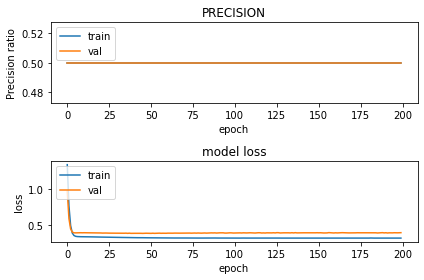

[0.3987676501274109, 0.5]


In [32]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)

# way to one hot encode the target variable into categorical variables
y_train = keras.utils.to_categorical(y_train, len(np.unique(y)))
y_val = keras.utils.to_categorical(y_val, len(np.unique(y)))


# need to do [1:] to allow for dimensionality compatability
a = b = keras.layers.Input(shape = x_train.shape[1:])

print('****** With Normalization Layer *******')
b = keras.layers.LayerNormalization(axis= -1)(b)

# look at keras.activations options
# make sure to functionalize the layer object so we pass tensors
b = keras.layers.Dense(y_train.shape[1], activation = keras.activations.softmax)(b)

# utilizing stochasisity to help find the best hyper parameters will be quicker than iterating through
batch_size = 32
epochs = 200

# engineer the learning rate so that it works with floats as randrange only works with ints
lr = .008


# reset the model
model = keras.Model(a,b)

# Prep the model for -learning-
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
optimizer='adam',
metrics=[keras.metrics.Precision(thresholds=0)])

# urn off print because we will look at the best model
history = model.fit(x_train, y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 2,
    validation_data = (x_val, y_val)
            )
# don't need to print out each evaluation
score = model.evaluate(x_val, y_val, verbose = 1)

plot_acc_loss(history)

print(score)

In [38]:
model.evaluate(x,y)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [34]:
from sklearn import metrics

threshold = 0.055

y = data['Attrition']
x = data.drop(columns=['EmployeeID','Attrition'])

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)

# way to one hot encode the target variable into categorical variables
y_train = keras.utils.to_categorical(y_train, len(np.unique(y)))
y_val = keras.utils.to_categorical(y_val, len(np.unique(y)))

output = model.predict(x_val)

output[output[:,1] > threshold] = [0,1]


actual = np.argmax(y_val, axis=-1)
predicted = np.argmax(output, axis=-1)

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


# incorrect = np.where(np.argmax(output,axis=-1) != np.argmax(y_val, axis=-1))
# correct = np.where(np.argmax(output,axis=-1) == np.argmax(y_val, axis=-1))
# print("Accuracy of predictions: ",(np.size(correct) / (np.size(incorrect) + np.size(correct))))
      
# incorrect_spots = incorrect[0]  
      
# print('**********Wrong Predictions**********')
# print('Number of wrong predictions: ', np.size(incorrect_spots))
# for i in range(np.size(incorrect_spots)):
#     print('Predicted class value at index', incorrect_spots[i], ': ', np.argmax(output[incorrect_spots[i]]))
#     print('Actual class value at index', incorrect_spots[i], ': ',np.argmax(y_val[incorrect_spots[i]]))

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [ ]:
np.argmax(output, axis=-1)

In [ ]:


def create_and_test_model(data, learning_rate_range_start, learning_rate_range_end, learning_rate_step
                          , val_accuracy_thresh, batch_size_range_start
                          , batch_size_range_end, batch_size_step, epoch_range_start
                          , epoch_range_end, epoch_range_step, iter_size, max_score, min_loss
                          , best_batch_size, best_num_epochs, best_lr, best_model, best_history, normalize = False):
    
    # take the data and split it into training and validation sets with proper encodings

    y = data['Attrition']
    x = data.drop(columns='Attrition')

    y.replace('No', 0, inplace=True)
    y.replace('Yes', 1, inplace = True)

    x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)

    # initialize the counter for the iterations, and the list to store the data   
    iteration = 0
    data_list = []

    # create loop to go through a large ranges of batch_size and epochs combinations to find the optimal combo
    while (max_score < val_accuracy_thresh) and (iteration < iter_size):


        # need to do [1:] to allow for dimensionality compatability
        a = b = keras.layers.Input(shape = x_train.shape[1:])
        
        if normalize:
            print('****** With Normalization Layer *******')
            b = keras.layers.LayerNormalization(axis= -1)(b)

        # look at keras.activations options
        # make sure to functionalize the layer object so we pass tensors
        b = keras.layers.Dense(1, activation = keras.activations.softmax)(b)
    
        # utilizing stochasisity to help find the best hyper parameters will be quicker than iterating through
        batch_size = rand.randrange(batch_size_range_start, batch_size_range_end, batch_size_step)
        epochs = rand.randrange(epoch_range_start, epoch_range_end, epoch_range_step)

        # engineer the learning rate so that it works with floats as randrange only works with ints
        lr = np.random.choice(np.arange(learning_rate_range_start, learning_rate_range_end, learning_rate_step), size=1)[0]
        print("batch size : ", batch_size, "...  epochs :", epochs,"... learning rate:" , lr,"...  iteration:", iteration)

        # reset the model
        model = keras.Model(a,b)

        # Prep the model for -learning-
        model.compile(loss=keras.losses.BinaryCrossentropy(log_ints=True),
        optimizer=keras.optimizers.SGD(learning_rate=lr),
        metrics=[keras.metrics.Recall(thresholds=0)])

        # urn off print because we will look at the best model
        history = model.fit(x_train, y_train,
            batch_size = batch_size,
            epochs = epochs,
            verbose = 2,
            validation_data = (x_val, y_val)
            )
        # don't need to print out each evaluation
        score = model.evaluate(x_val, y_val, verbose = 0)
        print("acc_score: ", score[1], "loss_value: ", score[0])

        if (score[1] > max_score):
            max_score = score[1]
            min_loss = score[0]
            best_batch_size = batch_size
            best_num_epochs = epochs
            best_lr = lr
            # make sure to use deepcopy so we get the object not a reference
            best_model = copy.deepcopy(model)
            best_history = copy.deepcopy(history)
        
        # increment the iteration
        iteration += 1
        
        row = [score[1], score[0], batch_size, epochs, lr]
        data_list.append(row)

    # create the dataframe with the data_list
    df = pd.DataFrame(data_list, columns=['score', 'loss', 'batch_size', 'epochs', 'learning_rate'])

    return df, max_score, min_loss, best_batch_size, best_num_epochs, best_lr, best_model, best_history

In [ ]:
df, max_score, min_loss, best_batch_score, best_num_epochs, best_lr,best_model, best_history = create_and_test_model(data, 0.005, 0.011, 0.001, 0.90, 2, 20, 2, 50, 300, 25, 5, 0, 100, 0, 0, 0, None, None, normalize = False)

In [ ]:
# show the locations where the predictions were wrong

# Validate the results of the loop

y = data['Attrition']
x = data.drop(columns='Attrition')

y.replace('No', 0, inplace=True)
y.replace('Yes', 1, inplace = True)

x_train, x_val, y_train, y_val = train_test_split(x,y, test_size =0.2, random_state=42)


output = best_model.predict(x_val)

incorrect = np.where(np.argmax(output,axis=-1) != np.argmax(y_val, axis=-1))
correct = np.where(np.argmax(output,axis=-1) == np.argmax(y_val, axis=-1))
print("Accuracy of predictions: ",(np.size(correct) / (np.size(incorrect) + np.size(correct))))
      
incorrect_spots = incorrect[0]  
      
print('**********Wrong Predictions**********')
print('Number of wrong predictions: ', np.size(incorrect_spots))
for i in range(np.size(incorrect_spots)):
    print('Predicted class value at index', incorrect_spots[i], ': ', np.argmax(output[incorrect_spots[i]]))
    print('Actual class value at index', incorrect_spots[i], ': ',np.argmax(y_val[incorrect_spots[i]]))

In [ ]:
history.history.keys()

In [ ]:
x_train